# Lindblad equation

### Master eq. for a N-qubits system

Vamos a resolver la evolución temporal de la matriz de densidad de un sistema de dos qubits. Primero se va a resolver haciendo todos los cálculos, para luego compararlo con una funcion solver de qiskit y comprobar que se ha calculado correctamente (https://qiskit-community.github.io/qiskit-dynamics/tutorials/Lindblad_dynamics_simulation).

La master equation que vamos a estudiar es:

$$\frac{d}{dt} \rho(t) = -j [H, \rho] + \Gamma \sum_i\left( \sigma^{-}_i \rho \sigma^{+}_i - \frac{1}{2} \left\{ \sigma^{+}_i \sigma^{-}_i, \rho \right\} \right)$$




El Hamiltoniano del sistema que se ha tomado es el del modelo  TFIM (transverse field Ising model):

$$ H = - \sum_{i=1}^{N} \left[ J \sigma_z^i \sigma_z^{i+1} + g \sigma_x^i \right],$$

donde el primer término corresponde a la interacción entre qubits por el modelo de Ising y el segundo al efecto del campo transversal.


Primero definimos los operadores sobre un qubit en el espacio de Hilbert de N qubits. Vamos a definir la matrices de Pauli sobre el qubit i, por ejemplo para pauli(x):

$$X_i = I_1 \otimes I_2 \otimes \cdots \otimes \sigma^{x}_i \otimes I_{i+1} \otimes \cdots \otimes I_N$$

Se va a usar la función Pauli, que detecta la dimensión del espacio al sumarle un operador de zeros con esa misma dimensión y devuelve la matriz de Pauli correspondiente.


A continuación, definimos el estado inicial de la matriz de densidad. En este caso se ha construido el estado de Bell $$|\psi\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$ mediante un circuito cuántico. Después, se dan valores a los parámetros y se calcula cada uno de los términos del Lindbladiano. 


Los operadores de salto son $$L_{\pm}=\sqrt{\Gamma}\sigma^{\pm}$$ con 

$$\sigma^{\pm} = \frac{1}{2} (\sigma^x \pm i \sigma^y)$$



Ahora evolucionamos el sistema con $$\rho[t+1]=\rho[t]+h\times (evolución)$$
donde $h$ es el paso de la simulación.

## Función para el cálculo del liouvilliano

In [709]:
import sympy as sp
from sympy.physics.quantum import Dagger
    
def calculate_liouvillian(H, L, n):
    sp.init_printing(use_unicode=True)  # Print bonito
    rho = sp.Matrix(n, n, lambda i, j: sp.symbols(f'rho_{i+1}{j+1}'))#defino rho como una matriz simbólica
    
    # Calculamos el adjunto de cada matriz L_q
    L_adj = [Dagger(L_q) for L_q in L]
    
    # Ahora operamos
    i = sp.I  # Def la unidad imaginaria
    
    # Cálculo de term1 y term2
    term1 = -i * (H * rho - rho * H)
    term2 = sp.Matrix.zeros(n, n)
    for q in range(int(n/2)):
        term2 += L[q] * rho * L_adj[q] - 0.5 * (L_adj[q] * L[q] * rho + rho * L_adj[q] * L[q])

    
    # Definir rho_t
    rho_t = (term1 + term2).reshape(n**2, 1) #espacio FL
    rho_vec=rho_t
    
    #cero un vector de variables rho_ij
    rho_vars = [rho[i, j] for i in range(n) for j in range(n)]
    
    # calculo el jacobiano respecto a los elementos de rho
    J = rho_t.jacobian(rho_vars)

    return J,rho_vec


## Cálculo del liouvilliano para el sistema de estudio

In [878]:
import numpy as np
from qiskit.quantum_info import Operator, Pauli

#tamaño del sistema
N = 2
n= 2**N #dim matriz
#guardo los operadores para cada qubit
x_ops = []
y_ops = []
z_ops = []
qubits = range(N)

#defino un operador de ceros, ya que la función Pauli detecta la dim al sumarle este operador y 
#devuelve la matriz de pauli correspondiente en esa dim
zeros = Operator(np.zeros((2 ** N, 2 ** N)))

for i in qubits:
    X =  Pauli('X')(i) + zeros
    x_ops.append(X)

    Y = zeros + Pauli('Y')(i)
    y_ops.append(Y)

    Z = zeros + Pauli('Z')(i)
    z_ops.append(Z)

#definimos algunos parámetros
g = 1.
J = 1.
Gamma = 4.


#definimos el hamiltoniano

H = np.zeros((2**N, 2**N), dtype=complex)
for i in qubits:
    X = x_ops[i]
    H -= g* X

    #término de interacción entre qubits
    if (N > 1) & (i<N-1):
        j = (i + 1)
        op = zeros + Pauli('ZZ')(i, j)
        H -= J * op
        
H_matrix = sp.Matrix(H)  # Convierte H a una matriz de numpy

#jump operators
L_op= []
for i in qubits:
     X = x_ops[i].data  # Convierte X a numpy
     Y = y_ops[i].data  # Convierte Y a numpy
     Z = z_ops[i].data  # Convierte Y a numpy
    
     #L= np.sqrt(Gamma) * 0.5 * (X + 1j * Y)
     L= np.sqrt(Gamma) * 0.5 * (Z)
     L_q=sp.Matrix(L) #importante que esté en este formato
     L_op.append(L_q)

liouvillian,rho_vec= calculate_liouvillian(H_matrix, L_op, n)
liouvillian


⎡  0        -1.0⋅ⅈ        -1.0⋅ⅈ       0        1.0⋅ⅈ        0       0          0           1.0⋅ⅈ        0       ↪
⎢                                                                                                                ↪
⎢-1.0⋅ⅈ  -2.0 + 2.0⋅ⅈ       0        -1.0⋅ⅈ       0        1.0⋅ⅈ     0          0             0        1.0⋅ⅈ     ↪
⎢                                                                                                                ↪
⎢-1.0⋅ⅈ       0        -2.0 + 2.0⋅ⅈ  -1.0⋅ⅈ       0          0     1.0⋅ⅈ        0             0          0     1 ↪
⎢                                                                                                                ↪
⎢  0        -1.0⋅ⅈ        -1.0⋅ⅈ      -4.0        0          0       0        1.0⋅ⅈ           0          0       ↪
⎢                                                                                                                ↪
⎢1.0⋅ⅈ        0             0          0     -2.0 - 2.0⋅ⅈ  -1.0⋅ⅈ  -1.0⋅ⅈ       

In [823]:
determinante=liouvillian.det()
determinante

In [824]:
from scipy.linalg import null_space
liouvillian= np.matrix(liouvillian).astype(np.complex64)
null_vector = null_space(liouvillian)

print("Vectores del espacio nulo (soluciones de Av = 0):")
print(null_vector)

Vectores del espacio nulo (soluciones de Av = 0):
[[-5.0000006e-01-0.0000000e+00j]
 [ 2.9802322e-08+4.8428774e-08j]
 [ 5.9604645e-08+4.0978193e-08j]
 [ 5.2154064e-08+5.0291419e-08j]
 [ 5.9604645e-08-5.9604645e-08j]
 [-4.9999997e-01+1.8626451e-08j]
 [-4.8428774e-08+1.3969839e-08j]
 [ 3.7252903e-08-3.7252903e-09j]
 [ 4.4703484e-08-0.0000000e+00j]
 [-2.9802322e-08-2.4214387e-08j]
 [-5.0000006e-01-2.2351742e-08j]
 [ 5.4948032e-08+4.0978193e-08j]
 [ 4.8428774e-08-4.6566129e-08j]
 [ 2.2351742e-08+2.5145710e-08j]
 [ 8.9406967e-08-1.1175871e-08j]
 [-5.0000000e-01+7.4505806e-09j]]


In [813]:
p00_data[1, t_i], p11_data[1, t_i], p22_data[1, t_i], p30_data[1, t_i], p01_data[1, t_i], p12_data[1, t_i], p23_data[1, t_i]

In [782]:
"""
sp.init_printing(use_unicode=True)  # Print bonito
eigenvects = liouvillian.eigenvects()  # Obtiene los autovalores
eigenvalues = liouvillian.eigenvals()  # Obtiene los autovectores
"""

In [820]:
#eigenvalues

In [821]:
#eigenvects[8][2]


## Evolución con el liouvilliano

In [825]:
from qiskit.quantum_info import DensityMatrix
from qiskit import QuantumCircuit
import numpy as np

# Circuito cuántico de 2 qubits en el estado de Bell |ψ⟩ = (|00⟩ + |11⟩) / √2
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)  
bell_circuit.cx(0, 1) 

# Definimos la matriz de densidad
rho_0 = DensityMatrix.from_instruction(bell_circuit)
rho_0_matrix = rho_0.data # Convierte rho_0 a una matriz de numpy

#guardamos la evolución de la matriz densidad en cada paso
rho=[]
rho.append(rho_0_matrix)
liouvillian= np.matrix(liouvillian).astype(np.complex64)
rho_t=rho_0_matrix.reshape(n**2, 1)

#ahora evolucionamos el sistema
t_final = 24./Gamma
tau = .0001 #tamaño del paso =paso
n_steps = int(np.ceil(t_final / tau)) +1
t_eval = np.linspace(0., t_final, n_steps)

for k in range(1,n_steps):
    rho_t+=tau*liouvillian*rho_t
    rho_t=rho_t/np.trace(rho_t.reshape(n, n))
    rho.append(rho_t.reshape(n, n))
    

C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\4199781024.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  p00_data[i, t_i] = (rho[t_i])[0][0]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\4199781024.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  p11_data[i, t_i] = (rho[t_i])[1][1]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\4199781024.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  p22_data[i, t_i] = (rho[t_i])[2][2]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\4199781024.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  p30_data[i, t_i] = (rho[t_i])[3][0]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\4199781024.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  p01_data[i, t_i] = (rho[t_i])[0][1]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\4199781024.py:20: ComplexWarning: Casting com

Text(0.5, 1.0, '$\\rho_{ii}$ vs. $t$')

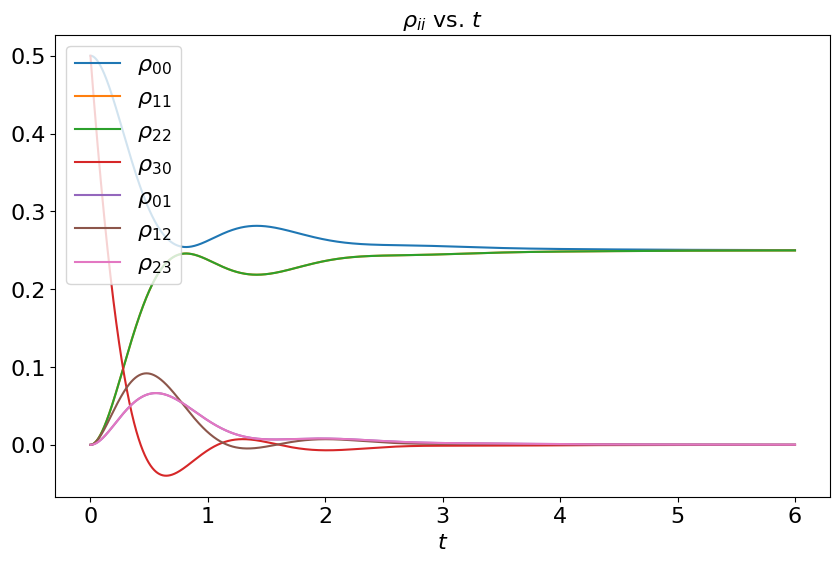

In [826]:
#representacion grafica

import matplotlib.pyplot as plt
%matplotlib inline
n_times = len(t_eval)
p00_data = np.zeros((N, n_times))
p11_data = np.zeros((N, n_times))
p22_data = np.zeros((N, n_times))
p30_data = np.zeros((N, n_times))
p01_data = np.zeros((N, n_times))
p12_data = np.zeros((N, n_times))
p23_data = np.zeros((N, n_times))
for t_i in range(n_steps):
    for i in qubits:
        p00_data[i, t_i] = (rho[t_i])[0][0]
        p11_data[i, t_i] = (rho[t_i])[1][1]
        p22_data[i, t_i] = (rho[t_i])[2][2]
        p30_data[i, t_i] = (rho[t_i])[3][0]
        p01_data[i, t_i] = (rho[t_i])[0][1]
        p12_data[i, t_i] = (rho[t_i])[1][2]
        p23_data[i, t_i] = (rho[t_i])[2][3]

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, p00_data[0,], label = '$\\rho_{00}$')
plt.plot(t_eval, p11_data[0,], label = '$\\rho_{11}$')
plt.plot(t_eval, p22_data[0,], label = '$\\rho_{22}$')
plt.plot(t_eval, p30_data[0,], label = '$\\rho_{30}$')
plt.plot(t_eval, p01_data[0,], label = '$\\rho_{01}$')
plt.plot(t_eval, p12_data[0,], label = '$\\rho_{12}$')
plt.plot(t_eval, p23_data[0,], label = '$\\rho_{23}$')

plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title(r'$\rho_{ii}$ vs. $t$', fontsize = fontsize)
    

## Evolución operando la Ec. de Lindblad

### Bloque para g cte

In [869]:
from qiskit.quantum_info import DensityMatrix
from qiskit import QuantumCircuit
import numpy as np

# Circuito cuántico de 2 qubits en el estado de Bell |ψ⟩ = (|00⟩ + |11⟩) / √2
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)  
bell_circuit.cx(0, 1) 

# Definimos la matriz de densidad
rho_0 = DensityMatrix.from_instruction(bell_circuit)
rho_t = rho_0.data  # Convierte rho_0 a una matriz de numpy

#guardamos la evolución de la matriz densidad en cada paso
rho=[]
rho.append(rho_t)

H_matrix=H.data

#ahora evolucionamos el sistema de ecuaciones diferenciales

t_final = 24./Gamma
tau = .0001 #tamaño del paso =paso
n_steps = int(np.ceil(t_final / tau)) +1
t_eval = np.linspace(0., t_final, n_steps)

for k in range(1,n_steps):
    #primer termino de la ecuacion de lindblad
    term1 = -1j * (np.dot(H_matrix, rho_t) - np.dot(rho_t, H_matrix))
    #segundo termino de la ecuacion de lindblad
    term2 = np.zeros((2**N, 2**N), dtype=complex)
    for i in qubits:
         X = x_ops[i].data  # Convierte X a numpy
         Y = y_ops[i].data  # Convierte Y a numpy
         Z = z_ops[i].data  # Convierte Y a numpy
         
         #L_mas = np.sqrt(Gamma) * 0.5 * (X + 1j * Y)
         L_mas = np.sqrt(Gamma) * 0.5 * (Z)
         L_menos = L_mas.conj().T  # Conjugado transpuesto para el operador de Lindblad
    
         term2 += np.dot(L_mas, np.dot(rho_t, L_menos)) - 0.5*(np.dot(L_menos, np.dot(L_mas, rho_t)) + np.dot(rho_t, np.dot(L_menos, L_mas))) 

    rho_t+=tau*(term1+term2) 
    rho_t=rho_t/np.trace(rho_t)
    rho.append(rho_t)


### Bloque para g con ruido

In [879]:
from qiskit.quantum_info import DensityMatrix
from qiskit import QuantumCircuit
import numpy as np

# Circuito cuántico de 2 qubits en el estado de Bell |ψ⟩ = (|00⟩ + |11⟩) / √2
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)  
bell_circuit.cx(0, 1) 

# Definimos la matriz de densidad
rho_0 = DensityMatrix.from_instruction(bell_circuit)


#hacemos repeticiones para caluclar la media con el ruido
for rep in range(1):    
    #guardamos la evolución de la matriz densidad en cada paso
    rho=[]
    rho_t = rho_0.data  # Convierte rho_0 a una matriz de numpy
    rho.append(rho_t)
    
    
    
    #ahora evolucionamos el sistema de ecuaciones diferenciales
    
    t_final = 24./Gamma
    tau = .0001 #tamaño del paso =paso
    n_steps = int(np.ceil(t_final / tau)) +1
    t_eval = np.linspace(0., t_final, n_steps)
    g=1.0
    
    for k in range(1,n_steps):
        #variamos el valor de g y actualizamos H
        g_ruido=g+np.random.normal(0, 0.3)
        H = np.zeros((2**N, 2**N), dtype=complex)
        for i in qubits:
            X = x_ops[i]
            H -= g_ruido* X
    
        #término de interacción entre qubits
        if (N > 1) & (i<N-1):
            j = (i + 1)
            op = zeros + Pauli('ZZ')(i, j)
            H -= J * op
        H_matrix=H.data    
        #primer termino de la ecuacion de lindblad
        term1 = -1j * (np.dot(H_matrix, rho_t) - np.dot(rho_t, H_matrix))
        #segundo termino de la ecuacion de lindblad
        term2 = np.zeros((2**N, 2**N), dtype=complex)
        for i in qubits:
             X = x_ops[i].data  # Convierte X a numpy
             Y = y_ops[i].data  # Convierte Y a numpy
             Z = z_ops[i].data  # Convierte Y a numpy
             
             #L_mas = np.sqrt(Gamma) * 0.5 * (X + 1j * Y)
             L_mas = np.sqrt(Gamma) * 0.5 * (Z)
             L_menos = L_mas.conj().T  # Conjugado transpuesto para el operador de Lindblad
        
             term2 += np.dot(L_mas, np.dot(rho_t, L_menos)) - 0.5*(np.dot(L_menos, np.dot(L_mas, rho_t)) + np.dot(rho_t, np.dot(L_menos, L_mas))) 
    
        rho_t+=tau*(term1+term2) 
        rho_t=rho_t/np.trace(rho_t)
        rho.append(rho_t)


Calculamos single-qubit Pauli expectation values para $\sigma^x$ para comparar luego con el obtenido en la función solver.

In [880]:
#calculamos observables
#single-qubit pauli expectation values
n_times = len(t_eval)
x_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))

for t_i in range(1,n_steps):
    for i in qubits:
        x_data[i, t_i] = np.trace(np.dot(x_ops[i].data,rho[t_i]))
    x_mean[t_i] = np.mean(x_data[:, t_i])


C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2004794317.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  x_data[i, t_i] = np.trace(np.dot(x_ops[i].data,rho[t_i]))


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2351590516.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(t_eval, x_data[0], label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')


Text(0.5, 1.0, 'Mean Bloch vector vs. $t$')

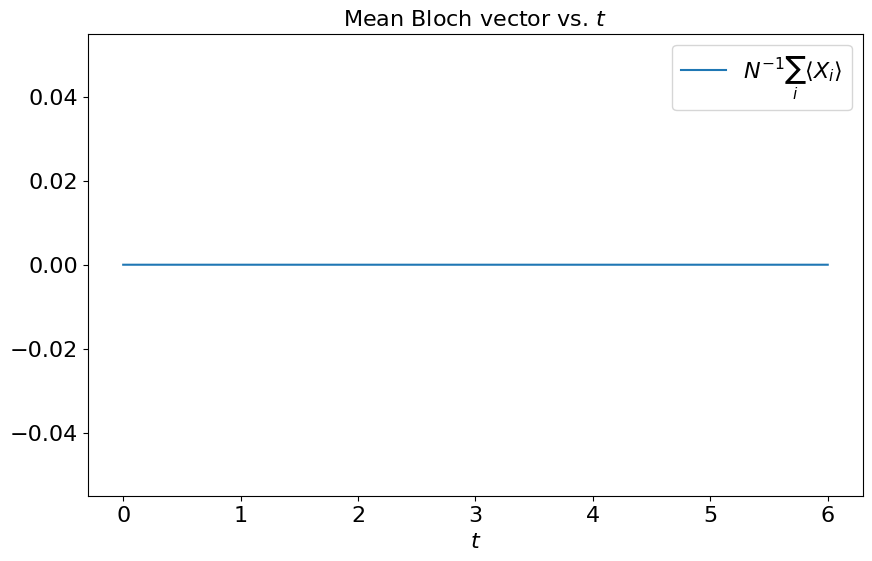

In [881]:
#plot del resultado
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, x_data[0], label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')

plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title('Mean Bloch vector vs. $t$', fontsize = fontsize)



A parte, vamos a representar la evolución de los términos diagonales de la matriz densidad:

C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2549965775.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  p00_data[i, t_i] = (rho[t_i])[0][0]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2549965775.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  p11_data[i, t_i] = (rho[t_i])[1][1]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2549965775.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  p22_data[i, t_i] = (rho[t_i])[2][2]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2549965775.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  p30_data[i, t_i] = (rho[t_i])[3][0]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2549965775.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  p01_data[i, t_i] = (rho[t_i])[0][1]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\2549965775.py:20: ComplexWarning: Casting com

Text(0.5, 1.0, '$\\rho_{ii}$ vs. $t$')

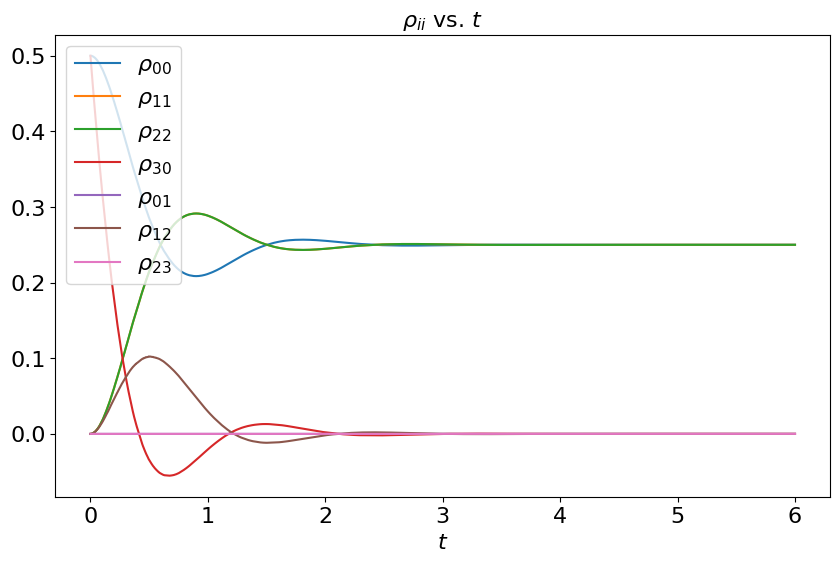

In [882]:
#diagonal matriz densidad p00, p11, p22, p33

import matplotlib.pyplot as plt
%matplotlib inline

p00_data = np.zeros((N, n_times))
p11_data = np.zeros((N, n_times))
p22_data = np.zeros((N, n_times))
p30_data = np.zeros((N, n_times))
p01_data = np.zeros((N, n_times))
p12_data = np.zeros((N, n_times))
p23_data = np.zeros((N, n_times))
for t_i in range(n_steps):
    for i in qubits:
        p00_data[i, t_i] = (rho[t_i])[0][0]
        p11_data[i, t_i] = (rho[t_i])[1][1]
        p22_data[i, t_i] = (rho[t_i])[2][2]
        p30_data[i, t_i] = (rho[t_i])[3][0]
        p01_data[i, t_i] = (rho[t_i])[0][1]
        p12_data[i, t_i] = (rho[t_i])[1][2]
        p23_data[i, t_i] = (rho[t_i])[2][3]

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, p00_data[0,], label = '$\\rho_{00}$')
plt.plot(t_eval, p11_data[0,], label = '$\\rho_{11}$')
plt.plot(t_eval, p22_data[0,], label = '$\\rho_{22}$')
plt.plot(t_eval, p30_data[0,], label = '$\\rho_{30}$')
plt.plot(t_eval, p01_data[0,], label = '$\\rho_{01}$')
plt.plot(t_eval, p12_data[0,], label = '$\\rho_{12}$')
plt.plot(t_eval, p23_data[0,], label = '$\\rho_{23}$')

plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title(r'$\rho_{ii}$ vs. $t$', fontsize = fontsize)
    

In [807]:
p00_data[1, t_i], p11_data[1, t_i], p22_data[1, t_i], p33_data[1, t_i], p01_data[1, t_i], p12_data[1, t_i], p23_data[1, t_i]

## Comprobación con solver

In [301]:
import numpy as np
from qiskit.quantum_info import Operator, Pauli

N = 2

#guardo los operadores para cada qubit
x_ops = []
y_ops = []
z_ops = []
qubits = range(N)

#defino un operador de ceros, ya que la función Pauli detecta la dim al sumarle este operador y 
#devuelve la matriz de pauli correspondiente en esa dim
zeros = Operator(np.zeros((2 ** N, 2 ** N)))

for i in qubits:
    X =  Pauli('X')(i) + zeros
    x_ops.append(X)

    Y = zeros + Pauli('Y')(i)
    y_ops.append(Y)

    Z = zeros + Pauli('Z')(i)
    z_ops.append(Z)


In [730]:
from qiskit_dynamics import Solver, Signal

g = 1.
J = 1.
Gamma = 4.

#definimos el hamiltoniano

H = np.zeros((2**N, 2**N), dtype=complex)
for i in qubits:
    X = x_ops[i]
    H -= g* X

    #término de interacción entre qubits
    if (N > 1) & (i<N-1):
        j = (i + 1)
        op = zeros + Pauli('ZZ')(i, j)
        H -= J * op
        
#jump operators, segundo termino de la ecuacion de lindblad
L_ops=[]
for i in qubits:
     X = x_ops[i]
     Y = y_ops[i] 
     L_ops.append(np.sqrt(Gamma) * 0.5 * (X + 1j * Y))

solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)

In [731]:
from qiskit.quantum_info import DensityMatrix

t_final = 8. / Gamma
tau = .01

# Crear un circuito cuántico de 2 qubits en el estado de Bell |ψ⟩ = (|00⟩ + |11⟩) / √2
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)  
bell_circuit.cx(0, 1)  

# Convertir el estado resultante en una matriz de densidad
y0 = DensityMatrix.from_instruction(bell_circuit)

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

sol = solver.solve(t_span=[0., t_final], y0=y0, t_eval=t_eval)

In [732]:
n_times = len(sol.y)
x_data = np.zeros((N, n_times))
y_data = np.zeros((N, n_times))
z_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))
y_mean = np.zeros((n_times,))
z_mean = np.zeros((n_times,))

for t_i, sol_t in enumerate(sol.y):
    for qubit, obs in enumerate(x_ops):
        x_data[qubit, t_i] = sol_t.expectation_value(obs).real
    x_mean[t_i] = np.mean(x_data[:, t_i])

    for qubit, obs in enumerate(y_ops):
        y_data[qubit, t_i] = sol_t.expectation_value(obs).real
    y_mean[t_i] = np.mean(y_data[:, t_i])

    for qubit, obs in enumerate(z_ops):
        z_data[qubit, t_i] = sol_t.expectation_value(obs).real
    z_mean[t_i] = np.mean(z_data[:, t_i])

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aileo\AppData\Local\Temp\ipykernel_15472\484671382.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(t_eval, x_data[1], label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')


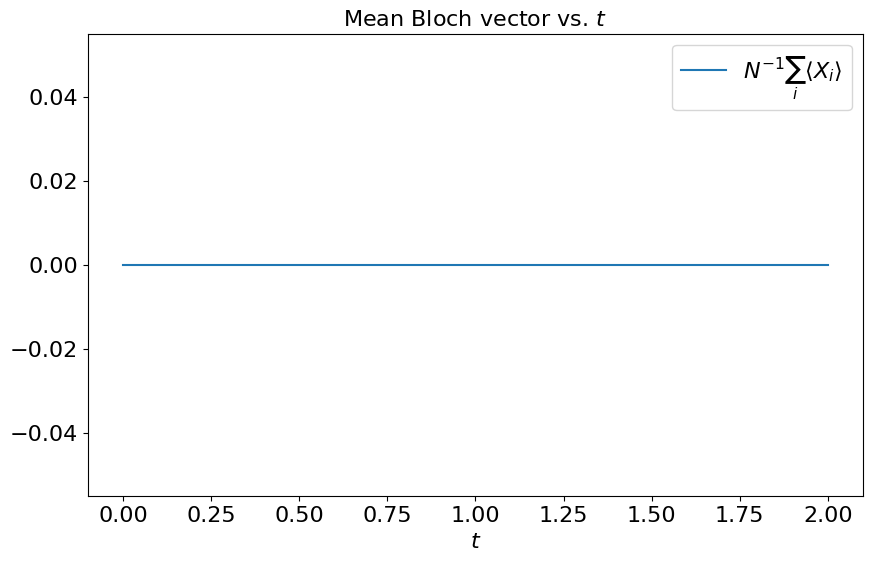

In [733]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, x_data[1], label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')
#plt.plot(t_eval, y_mean, label = '$ N^{-1}\sum_i \\langle Y_i \\rangle$')
#plt.plot(t_eval, z_mean, label = '$ N^{-1}\sum_i \\langle Z_i \\rangle$')
plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title('Mean Bloch vector vs. $t$', fontsize = fontsize)


if N > 1 and ((abs(x_mean[-1]) > 1e-5 and abs(x_data[0, -1] / x_mean[-1] - 1) > 1e-5 or
              (abs(z_mean[-1]) > 1e-5 and abs(z_data[1, -1] / z_mean[-1] - 1) > 1e-5))):
    print("The solution at the final time appears to break translation invariance. "
          "The precision of the simulation should be examined.")

# etc

In [370]:
import sympy as sp
from sympy.physics.quantum import Dagger

sp.init_printing(use_unicode=True) #print bonito

#definimos un hamiltoniano generico

n = sp.symbols('n', integer=True)  # Puedes especificar un valor específico de n si lo conoces
n=2
H = sp.Matrix(n, n, lambda i, j: sp.symbols(f'h_{i+1}{j+1}'))
rho = sp.Matrix(n, n, lambda i, j: sp.symbols(f'rho_{i+1}{j+1}'))

L = []
for q in range(int(n/2)):  #cada qubit
    L_q = sp.Matrix(n, n, lambda i, j: sp.symbols(f'L_{i+1}{j+1}^{q}')) 
    L.append(L_q)

# Calculamos el adjunto de cada matriz L_q
L_adj = [Dagger(L_q) for L_q in L]

#ahora operamos

i=sp.I #def la unidad imaginaria
gamma = sp.symbols('Gamma')


term1=-i*(H*rho-rho*H)
term2=sp.Matrix.zeros(n,n)
for q in range(int(n/2)):
    term2+=L_adj[q]*rho*L[q]-1/2*(L[q]*L_adj[q]*rho+rho*L[q]*L_adj[q])

term2_simplified = sp.simplify(term2)
rho_t= (term1+gamma*term2)



### Comprobación con el paper de Dani

In [768]:
#definimos las matrices
n=2
gamma=4.
# Definir un Hamiltoniano H con valores numéricos
H = sp.Matrix([[1.0, 0.5], 
               [0.5, 1.0]])

# Definir operadores de salto L con valores numéricos
L = [
    sp.Matrix([[0.0, np.sqrt(gamma)*1.0], 
                [0.0, 0.0]]),  # L_1
]

liouvillian,a= calculate_liouvillian(H, L, n)
L

⎡⎡0.0  2.0⎤⎤
⎢⎢        ⎥⎥
⎣⎣0.0  0.0⎦⎦

In [711]:
sp.init_printing(use_unicode=True)  # Print bonito
eigenvalues = liouvillian.eigenvals()  # Obtiene los autovalores
eigenvectors = liouvillian.eigenvects()  # Obtiene los autovectores


In [712]:
eigenvalues

In [713]:
eigenvectors

⎡⎛         ⎡⎡-6.83680877694706e-64⎤⎤⎞  ⎛                         ⎡⎡  -0.9473729613781  ⎤⎤⎞  ⎛         ⎡⎡ 0.51290534 ↪
⎢⎜         ⎢⎢                     ⎥⎥⎟  ⎜                         ⎢⎢                    ⎥⎥⎟  ⎜         ⎢⎢            ↪
⎢⎜         ⎢⎢ 0.707106781186548⋅ⅈ ⎥⎥⎟  ⎜                         ⎢⎢-0.222911285030141⋅ⅈ⎥⎥⎟  ⎜         ⎢⎢-0.51290534 ↪
⎢⎜-2.0, 1, ⎢⎢                     ⎥⎥⎟, ⎜-1.6376905061258e-64, 1, ⎢⎢                    ⎥⎥⎟, ⎜-3.0, 1, ⎢⎢            ↪
⎢⎜         ⎢⎢ 0.707106781186548⋅ⅈ ⎥⎥⎟  ⎜                         ⎢⎢0.222911285030141⋅ⅈ ⎥⎥⎟  ⎜         ⎢⎢0.512905347 ↪
⎢⎜         ⎢⎢                     ⎥⎥⎟  ⎜                         ⎢⎢                    ⎥⎥⎟  ⎜         ⎢⎢            ↪
⎣⎝         ⎣⎣2.27893625898235e-64 ⎦⎦⎠  ⎝                         ⎣⎣-0.0557278212575353 ⎦⎦⎠  ⎝         ⎣⎣ -0.5129053 ↪

↪ 7432484  ⎤⎤⎞  ⎛         ⎡⎡ 0.512905347432484  ⎤⎤⎞⎤
↪          ⎥⎥⎟  ⎜         ⎢⎢                    ⎥⎥⎟⎥
↪ 7432484⋅ⅈ⎥⎥⎟  ⎜         ⎢⎢-0.512905347432484⋅ⅈ⎥⎥⎟⎥
↪          ⎥⎥⎟